# Test DUAL Confidence-Based Document Classification

This notebook tests the **DUAL indexing approach** with confidence-based classification that combines:
- 📸 **IMAGE collection** (OpenCLIP visual embeddings)  
- 📝 **TEXT collection** (SentenceTransformer + OCR text embeddings)
- 🎯 **Confidence-based final classification** (chooses winner based on higher confidence)

## 🔬 Testing Goals:
1. **Accuracy Comparison**: Test if dual confidence approach improves classification accuracy
2. **Modality Analysis**: Determine which modality (image vs text) wins for each document type
3. **Confidence Evaluation**: Analyze confidence scores and prediction reliability
4. **Performance Benchmarks**: Compare dual approach vs single-modality approaches

In [1]:
# Install required packages for dual confidence-based classification
%pip install pillow chromadb tqdm scikit-learn seaborn numpy pytesseract

import os
import glob
from pathlib import Path
from PIL import Image
import numpy as np
import chromadb
from chromadb.utils.embedding_functions.open_clip_embedding_function import OpenCLIPEmbeddingFunction
from chromadb.utils.embedding_functions.sentence_transformer_embedding_function import SentenceTransformerEmbeddingFunction
from tqdm import tqdm
import hashlib
import json
from datetime import datetime
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from functools import partial
import concurrent.futures
import psutil
import pytesseract

# Fix tokenizers parallelism warning when using with pytesseract
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("✅ Imports loaded successfully!")
print(f"💻 System: {mp.cpu_count()} CPU cores, {psutil.virtual_memory().total // (1024**3):.1f}GB RAM")
print("🎯 Ready for DUAL confidence-based classification testing!")


Note: you may need to restart the kernel to use updated packages.
✅ Imports loaded successfully!
💻 System: 14 CPU cores, 48.0GB RAM
🎯 Ready for DUAL confidence-based classification testing!


In [2]:
# Performance and Optimization Configuration
print("🚀 Optimized Document Image Classification System")
print("=" * 50)

# Display system optimization info
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available RAM: {psutil.virtual_memory().total // (1024**3):.1f} GB")

print("✅ Image-based classification using OpenCLIP embeddings")
print("  - Direct image embedding without OCR")
print("  - Multimodal similarity search")
print("  - Optimized memory management")

print("\n🔧 Optimization Features:")
print("  ✓ Parallel image processing")
print("  ✓ Batch image embedding")
print("  ✓ Batch similarity search")
print("  ✓ Direct image-to-vector conversion")
print("  ✓ Progress tracking")

# Configuration options
BATCH_SIZE_SMALL = 16    # For small test runs
BATCH_SIZE_MEDIUM = 32   # For k-value comparison (reduced for images)
BATCH_SIZE_LARGE = 64    # For full evaluation (reduced for images)
MAX_IMAGE_WORKERS = min(mp.cpu_count(), 6)  # Optimal image processing thread count

print(f"\n⚙️  Batch Sizes: Small={BATCH_SIZE_SMALL}, Medium={BATCH_SIZE_MEDIUM}, Large={BATCH_SIZE_LARGE}")
print(f"🧵 Max Image Workers: {MAX_IMAGE_WORKERS}")
print("=" * 50)


🚀 Optimized Document Image Classification System
Available CPU cores: 14
Available RAM: 48.0 GB
✅ Image-based classification using OpenCLIP embeddings
  - Direct image embedding without OCR
  - Multimodal similarity search
  - Optimized memory management

🔧 Optimization Features:
  ✓ Parallel image processing
  ✓ Batch image embedding
  ✓ Batch similarity search
  ✓ Direct image-to-vector conversion
  ✓ Progress tracking

⚙️  Batch Sizes: Small=16, Medium=32, Large=64
🧵 Max Image Workers: 6


In [3]:
# Configuration for DUAL indexing approach testing
TEST_DOCS_PATH = "../output/docs-sm_test"  # Test documents path
CHROMA_DB_PATH = "../chroma_db_dual"  # DUAL ChromaDB path (from multimodal dual indexing)
IMAGE_COLLECTION_NAME = "smartdoc_images"  # IMAGE collection name  
TEXT_COLLECTION_NAME = "smartdoc_texts"   # TEXT collection name

# Supported image extensions
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.tiff', '.bmp'}

print("🎯 DUAL Confidence-Based Classification Testing Configuration")
print("=" * 60)
print(f"Test documents path: {TEST_DOCS_PATH}")
print(f"DUAL ChromaDB path: {CHROMA_DB_PATH}")
print(f"  📸 IMAGE collection: {IMAGE_COLLECTION_NAME}")
print(f"  📝 TEXT collection: {TEXT_COLLECTION_NAME}")
print()
print(f"Supported formats: {', '.join(IMAGE_EXTENSIONS)}")
print("=" * 60)


🎯 DUAL Confidence-Based Classification Testing Configuration
Test documents path: ../output/docs-sm_test
DUAL ChromaDB path: ../chroma_db_dual
  📸 IMAGE collection: smartdoc_images
  📝 TEXT collection: smartdoc_texts

Supported formats: .jpg, .tiff, .jpeg, .png, .bmp


In [4]:
def get_test_image_files(base_path):
    """
    Get all test image files with their true document types.
    
    Args:
        base_path (str): Base path to search for test image files
        
    Returns:
        list: List of tuples (file_path, true_document_type)
    """
    image_files = []
    base_path = Path(base_path)
    
    if not base_path.exists():
        print(f"Warning: Path {base_path} does not exist!")
        return image_files
    
    # Iterate through document type folders
    for doc_type_folder in base_path.iterdir():
        if doc_type_folder.is_dir():
            doc_type = doc_type_folder.name
            print(f"Scanning test folder: {doc_type}")
            
            # Find all image files in this folder
            for file_path in doc_type_folder.iterdir():
                if file_path.is_file() and file_path.suffix.lower() in IMAGE_EXTENSIONS:
                    image_files.append((str(file_path), doc_type))
    
    print(f"Found {len(image_files)} test image files total")
    return image_files

# Get all test image files
test_image_files = get_test_image_files(TEST_DOCS_PATH)

# Show test set statistics
test_doc_types = {}
for _, doc_type in test_image_files:
    test_doc_types[doc_type] = test_doc_types.get(doc_type, 0) + 1

print("\nTest set document type distribution:")
for doc_type, count in sorted(test_doc_types.items()):
    print(f"  {doc_type}: {count} files")


Scanning test folder: form
Scanning test folder: news_article
Scanning test folder: handwritten
Scanning test folder: resume
Scanning test folder: letter
Scanning test folder: specification
Scanning test folder: questionnaire
Scanning test folder: memo
Scanning test folder: scientific_report
Scanning test folder: scientific_publication
Scanning test folder: file_folder
Scanning test folder: advertisement
Scanning test folder: presentation
Scanning test folder: email
Scanning test folder: invoice
Scanning test folder: budget
Found 742 test image files total

Test set document type distribution:
  advertisement: 49 files
  budget: 53 files
  email: 43 files
  file_folder: 46 files
  form: 49 files
  handwritten: 48 files
  invoice: 45 files
  letter: 47 files
  memo: 46 files
  news_article: 40 files
  presentation: 47 files
  questionnaire: 46 files
  resume: 46 files
  scientific_publication: 46 files
  scientific_report: 46 files
  specification: 45 files


In [5]:
# Setup DUAL Collections and Confidence-Based Classification Functions
print("🎨 Setting up DUAL indexing collections for confidence-based classification...")

# Initialize embedding functions
image_ef = OpenCLIPEmbeddingFunction()
text_ef = SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

# Connect to DUAL ChromaDB
try:
    dual_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
    
    # Load IMAGE collection
    image_collection = dual_client.get_collection(name=IMAGE_COLLECTION_NAME)
    print(f"✅ Loaded IMAGE collection '{IMAGE_COLLECTION_NAME}' with {image_collection.count()} documents")
    
    # Load TEXT collection  
    text_collection = dual_client.get_collection(name=TEXT_COLLECTION_NAME)
    print(f"✅ Loaded TEXT collection '{TEXT_COLLECTION_NAME}' with {text_collection.count()} documents")
    
    dual_collections_available = True
    
except Exception as e:
    print(f"❌ Error loading DUAL collections: {str(e)}")
    print("Make sure you've run the dual indexing notebook (08_document_multimodal_dual_indexing.ipynb) first!")
    dual_collections_available = False

print(f"📊 Collections Status:")
print(f"  🎯 DUAL collections: {'✅ Available' if dual_collections_available else '❌ Not available'}")

def create_document_id(file_path):
    """Create a unique document ID based on file path."""
    return hashlib.md5(file_path.encode()).hexdigest()

def extract_text_from_image(image_path):
    """Extract text from an image using OCR (pytesseract)."""
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            text = pytesseract.image_to_string(img, lang='eng')
            text = text.strip()
            text = ' '.join(text.split())  # Remove excessive whitespace
            
            return text
    except Exception as e:
        print(f"⚠️  Error extracting text from {os.path.basename(image_path)}: {str(e)}")
        return ""

def load_image_as_array(image_path):
    """Load an image and convert it to a numpy array format expected by ChromaDB."""
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            image_array = np.array(img)
            return image_array
    except Exception as e:
        print(f"⚠️  Error loading image {os.path.basename(image_path)}: {str(e)}")
        return None

def analyze_classification_confidence(search_results, modality):
    """
    Analyze classification confidence based on search results.
    Uses distance-based voting with confidence scoring.
    """
    if not search_results or not search_results['metadatas'][0]:
        return None, 0.0
    
    # Count document types weighted by similarity
    doc_type_scores = {}
    total_weight = 0
    
    for metadata, distance in zip(search_results['metadatas'][0], search_results['distances'][0]):
        doc_type = metadata['document_type']
        # Convert distance to similarity (closer = higher similarity)
        similarity = 1 - distance
        # Weight by similarity (higher similarity = more influence)
        weight = max(0, similarity)  # Ensure non-negative
        
        if doc_type not in doc_type_scores:
            doc_type_scores[doc_type] = 0
        doc_type_scores[doc_type] += weight
        total_weight += weight
    
    if total_weight == 0:
        return None, 0.0
    
    # Normalize scores to get confidence percentages
    for doc_type in doc_type_scores:
        doc_type_scores[doc_type] /= total_weight
    
    # Get the top prediction and its confidence
    predicted_class = max(doc_type_scores, key=doc_type_scores.get)
    confidence = doc_type_scores[predicted_class]
    
    return predicted_class, confidence

def determine_final_classification(image_class, image_conf, text_class, text_conf):
    """
    Determine final classification based on confidence levels from both modalities.
    """
    # If only one modality has results
    if image_class and not text_class:
        return image_class, image_conf, "image_only"
    elif text_class and not image_class:
        return text_class, text_conf, "text_only"
    elif not image_class and not text_class:
        return None, 0.0, "no_results"
    
    # Both modalities have results - compare confidence
    if image_conf > text_conf:
        winning_modality = "image"
        final_class = image_class
        final_confidence = image_conf
    elif text_conf > image_conf:
        winning_modality = "text"
        final_class = text_class
        final_confidence = text_conf
    else:
        # Tie - prefer image (or could use other tie-breaking logic)
        winning_modality = "image_tie"
        final_class = image_class
        final_confidence = image_conf
    
    return final_class, final_confidence, winning_modality

def search_with_dual_confidence(query_image_path, image_top_k=3, text_top_k=7):
    """
    Search using DUAL indexing approach with confidence-based classification.
    
    Args:
        query_image_path: Path to query image
        image_top_k: Number of results to retrieve from IMAGE collection (default: 3)
        text_top_k: Number of results to retrieve from TEXT collection (default: 7)
    
    Returns:
        dict: Combined results with confidence-based classification
    """
    # Load and process query image
    query_image_array = load_image_as_array(query_image_path)
    if query_image_array is None:
        return None
    
    # Extract OCR text from query image
    query_text = extract_text_from_image(query_image_path)
    
    # Search IMAGE collection with image_top_k
    try:
        image_results = image_collection.query(
            query_images=[query_image_array],
            n_results=image_top_k,
            include=["metadatas", "distances"]
        )
        image_classification, image_confidence = analyze_classification_confidence(
            image_results, "image"
        )
    except Exception as e:
        image_classification, image_confidence = None, 0.0
    
    # Search TEXT collection with text_top_k (if we have text)
    text_classification, text_confidence = None, 0.0
    if query_text:
        try:
            text_results = text_collection.query(
                query_texts=[query_text],
                n_results=text_top_k,
                include=["metadatas", "distances"]
            )
            text_classification, text_confidence = analyze_classification_confidence(
                text_results, "text"
            )
        except Exception as e:
            pass
    
    # Confidence-based final classification
    final_classification, final_confidence, winning_modality = determine_final_classification(
        image_classification, image_confidence,
        text_classification, text_confidence
    )
    
    return {
        "query_image": query_image_path,
        "query_text": query_text,
        "image_classification": image_classification,
        "image_confidence": image_confidence,
        "text_classification": text_classification, 
        "text_confidence": text_confidence,
        "final_classification": final_classification,
        "final_confidence": final_confidence,
        "winning_modality": winning_modality,
        "image_top_k": image_top_k,
        "text_top_k": text_top_k
    }

print("✅ DUAL confidence-based classification functions ready!")
if dual_collections_available:
    print("🎯 Ready to test confidence-based classification!")
else:
    print("⚠️  DUAL collections not available - only legacy testing possible")


🎨 Setting up DUAL indexing collections for confidence-based classification...


/Users/ivan/Workspace/agentai-document-data-extractor/smartdoc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded IMAGE collection 'smartdoc_images' with 3494 documents
✅ Loaded TEXT collection 'smartdoc_texts' with 3366 documents
📊 Collections Status:
  🎯 DUAL collections: ✅ Available
✅ DUAL confidence-based classification functions ready!
🎯 Ready to test confidence-based classification!


In [6]:
# DUAL Classification and Legacy Comparison Functions

def predict_document_type_dual_confidence(query_image_path, image_top_k=3, text_top_k=7):
    """
    Predict document type using DUAL confidence-based classification.
    
    Args:
        query_image_path (str): Path to the query image
        image_top_k (int): Number of similar documents to consider for IMAGE search (default: 3)
        text_top_k (int): Number of similar documents to consider for TEXT search (default: 7)
        
    Returns:
        dict: Complete dual classification results
    """
    if not dual_collections_available:
        return None
    
    return search_with_dual_confidence(query_image_path, image_top_k=image_top_k, text_top_k=text_top_k)

def predict_document_type_legacy(query_image, top_k=5):
    """
    Legacy prediction using single image collection for comparison.
    
    Args:
        query_image (np.array): Image array from test document
        top_k (int): Number of similar documents to consider for prediction
        
    Returns:
        tuple: (predicted_type, confidence, search_results)
    """
    if not legacy_collection_available:
        return None, 0.0, None
    
    try:
        results = legacy_collection.query(
            query_images=[query_image],
            n_results=top_k,
            include=["metadatas", "distances"]
        )
        
        if not results['metadatas'][0]:
            return None, 0.0, None
        
        # Extract document types from similar documents
        similar_doc_types = []
        for metadata in results['metadatas'][0]:
            similar_doc_types.append(metadata['document_type'])
        
        # Majority voting
        type_counts = Counter(similar_doc_types)
        predicted_type = type_counts.most_common(1)[0][0]
        confidence = type_counts[predicted_type] / len(similar_doc_types)
        
        return predicted_type, confidence, results
        
    except Exception as e:
        print(f"Error in legacy prediction: {str(e)}")
        return None, 0.0, None

def evaluate_dual_classification(test_files, image_top_k=3, text_top_k=7, max_samples=None):
    """
    Evaluate DUAL confidence-based classification on test set.
    
    Args:
        test_files (list): List of (file_path, true_type) tuples
        image_top_k (int): Number of similar documents to consider for IMAGE search (default: 3)
        text_top_k (int): Number of similar documents to consider for TEXT search (default: 7)
        max_samples (int): Maximum number of samples to test (None for all)
        
    Returns:
        dict: Classification results and metrics with modality analysis
    """
    if not dual_collections_available:
        print("❌ DUAL collections not available for testing!")
        return None
    
    if max_samples:
        test_files = test_files[:max_samples]
        print(f"Testing DUAL approach on {max_samples} samples only")
    
    print(f"🎯 Starting DUAL confidence-based classification evaluation...")
    print(f"📸 Using IMAGE collection: {image_collection.count()} documents")
    print(f"📝 Using TEXT collection: {text_collection.count()} documents")
    print(f"🔍 IMAGE Top-K: {image_top_k}, TEXT Top-K: {text_top_k}")
    
    # Results containers
    true_labels = []
    predicted_labels = []
    final_confidences = []
    image_classifications = []
    image_confidences = []
    text_classifications = []
    text_confidences = []
    winning_modalities = []
    
    failed_predictions = 0
    
    # Process each test file
    for i, (file_path, true_type) in enumerate(tqdm(test_files, desc="DUAL classification")):
        try:
            # Run dual confidence classification
            results = predict_document_type_dual_confidence(file_path, image_top_k=image_top_k, text_top_k=text_top_k)
            
            if results and results['final_classification']:
                true_labels.append(true_type)
                predicted_labels.append(results['final_classification'])
                final_confidences.append(results['final_confidence'])
                
                # Store modality-specific results
                image_classifications.append(results['image_classification'])
                image_confidences.append(results['image_confidence'])
                text_classifications.append(results['text_classification'])
                text_confidences.append(results['text_confidence'])
                winning_modalities.append(results['winning_modality'])
            else:
                failed_predictions += 1
                
        except Exception as e:
            print(f"Error processing {os.path.basename(file_path)}: {str(e)}")
            failed_predictions += 1
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels) if true_labels else 0.0
    avg_confidence = np.mean(final_confidences) if final_confidences else 0.0
    
    # Analyze modality performance
    modality_stats = {}
    for modality in set(winning_modalities):
        modality_count = winning_modalities.count(modality)
        modality_stats[modality] = {
            'count': modality_count,
            'percentage': modality_count / len(winning_modalities) * 100 if winning_modalities else 0
        }
    
    # Calculate per-class confidence statistics
    class_confidence_stats = {}
    for i, true_label in enumerate(true_labels):
        if true_label not in class_confidence_stats:
            class_confidence_stats[true_label] = {
                'confidences': [],
                'total_samples': 0,
                'correct_predictions': 0
            }
        
        class_confidence_stats[true_label]['confidences'].append(final_confidences[i])
        class_confidence_stats[true_label]['total_samples'] += 1
        
        # Track correct predictions for per-class accuracy
        if true_label == predicted_labels[i]:
            class_confidence_stats[true_label]['correct_predictions'] += 1
    
    # Calculate averages for each class
    for class_name in class_confidence_stats:
        confidences = class_confidence_stats[class_name]['confidences']
        class_confidence_stats[class_name]['avg_confidence'] = np.mean(confidences) if confidences else 0.0
        class_confidence_stats[class_name]['std_confidence'] = np.std(confidences) if confidences else 0.0
        class_confidence_stats[class_name]['min_confidence'] = np.min(confidences) if confidences else 0.0
        class_confidence_stats[class_name]['max_confidence'] = np.max(confidences) if confidences else 0.0
        class_confidence_stats[class_name]['accuracy'] = (
            class_confidence_stats[class_name]['correct_predictions'] / 
            class_confidence_stats[class_name]['total_samples']
        ) if class_confidence_stats[class_name]['total_samples'] > 0 else 0.0
    
    results = {
        'true_labels': true_labels,
        'predicted_labels': predicted_labels,
        'final_confidences': final_confidences,
        'image_classifications': image_classifications,
        'image_confidences': image_confidences,
        'text_classifications': text_classifications,
        'text_confidences': text_confidences,
        'winning_modalities': winning_modalities,
        'accuracy': accuracy,
        'avg_confidence': avg_confidence,
        'total_samples': len(test_files),
        'successful_predictions': len(true_labels),
        'failed_predictions': failed_predictions,
        'image_top_k': image_top_k,
        'text_top_k': text_top_k,
        'modality_stats': modality_stats,
        'class_confidence_stats': class_confidence_stats
    }
    
    return results

def analyze_class_confidence_thresholds(dual_results, target_accuracy=0.95):
    """
    Analyze per-class confidence statistics and suggest optimal thresholds.
    
    Args:
        dual_results (dict): Results from evaluate_dual_classification
        target_accuracy (float): Target accuracy for threshold calculation
        
    Returns:
        dict: Suggested thresholds per class
    """
    if not dual_results or 'class_confidence_stats' not in dual_results:
        print("❌ No class confidence statistics available")
        return {}
    
    print("📊 PER-CLASS CONFIDENCE ANALYSIS")
    print("=" * 70)
    
    class_stats = dual_results['class_confidence_stats']
    suggested_thresholds = {}
    
    # Sort classes by sample count for better readability
    sorted_classes = sorted(class_stats.keys(), 
                          key=lambda x: class_stats[x]['total_samples'], 
                          reverse=True)
    
    for class_name in sorted_classes:
        stats = class_stats[class_name]
        
        print(f"\n📋 {class_name.upper()}:")
        print(f"   📊 Samples: {stats['total_samples']}")
        print(f"   🎯 Accuracy: {stats['accuracy']:.3f} ({stats['accuracy']*100:.1f}%)")
        print(f"   📈 Avg Confidence: {stats['avg_confidence']:.3f}")
        print(f"   📏 Std Confidence: {stats['std_confidence']:.3f}")
        print(f"   🔽 Min Confidence: {stats['min_confidence']:.3f}")
        print(f"   🔼 Max Confidence: {stats['max_confidence']:.3f}")
        
        # Calculate suggested threshold based on confidence distribution
        confidences = stats['confidences']
        if confidences:
            # Use percentile-based threshold (e.g., 10th percentile as conservative threshold)
            conservative_threshold = np.percentile(confidences, 10)
            moderate_threshold = np.percentile(confidences, 25)
            liberal_threshold = stats['avg_confidence'] - stats['std_confidence']
            
            print(f"   💡 Suggested Thresholds:")
            print(f"      🔒 Conservative (10th percentile): {conservative_threshold:.3f}")
            print(f"      📊 Moderate (25th percentile): {moderate_threshold:.3f}")
            print(f"      🚀 Liberal (avg - std): {max(0.0, liberal_threshold):.3f}")
            
            # Store the moderate threshold as default suggestion
            suggested_thresholds[class_name] = moderate_threshold
        else:
            suggested_thresholds[class_name] = 0.5  # Default fallback
    
    print("\n🎯 RECOMMENDED CLASS-WISE THRESHOLDS:")
    print("=" * 50)
    for class_name, threshold in sorted(suggested_thresholds.items()):
        accuracy = class_stats[class_name]['accuracy']
        avg_conf = class_stats[class_name]['avg_confidence']
        print(f"  {class_name:20}: {threshold:.3f} (acc: {accuracy:.3f}, avg_conf: {avg_conf:.3f})")
    
    return suggested_thresholds

def apply_class_wise_thresholds(dual_results, class_thresholds):
    """
    Apply class-wise confidence thresholds and calculate performance.
    
    Args:
        dual_results (dict): Results from evaluate_dual_classification
        class_thresholds (dict): Threshold per class
        
    Returns:
        dict: Performance with applied thresholds
    """
    if not dual_results or 'true_labels' not in dual_results:
        print("❌ No dual results available")
        return {}
    
    true_labels = dual_results['true_labels']
    predicted_labels = dual_results['predicted_labels']
    confidences = dual_results['final_confidences']
    
    # Apply thresholds
    filtered_predictions = []
    filtered_true_labels = []
    rejected_count = 0
    
    for i, (true_label, pred_label, confidence) in enumerate(zip(true_labels, predicted_labels, confidences)):
        threshold = class_thresholds.get(true_label, 0.5)  # Default threshold if class not found
        
        if confidence >= threshold:
            filtered_predictions.append(pred_label)
            filtered_true_labels.append(true_label)
        else:
            rejected_count += 1
    
    # Calculate metrics with thresholds applied
    if filtered_predictions:
        threshold_accuracy = accuracy_score(filtered_true_labels, filtered_predictions)
        coverage = len(filtered_predictions) / len(true_labels)
    else:
        threshold_accuracy = 0.0
        coverage = 0.0
    
    print(f"\n📊 PERFORMANCE WITH CLASS-WISE THRESHOLDS:")
    print("=" * 50)
    print(f"   📈 Accuracy (with thresholds): {threshold_accuracy:.3f} ({threshold_accuracy*100:.1f}%)")
    print(f"   📊 Coverage: {coverage:.3f} ({coverage*100:.1f}%)")
    print(f"   ❌ Rejected predictions: {rejected_count}/{len(true_labels)}")
    print(f"   🔄 Original accuracy: {dual_results['accuracy']:.3f} ({dual_results['accuracy']*100:.1f}%)")
    
    return {
        'threshold_accuracy': threshold_accuracy,
        'coverage': coverage,
        'rejected_count': rejected_count,
        'original_accuracy': dual_results['accuracy'],
        'filtered_predictions': filtered_predictions,
        'filtered_true_labels': filtered_true_labels
    }

print("✅ DUAL evaluation functions ready!")
print("🎯 Ready for optimized parallel DUAL confidence-based classification!")
print("📊 Added per-class confidence analysis and threshold optimization!")


✅ DUAL evaluation functions ready!
🎯 Ready for optimized parallel DUAL confidence-based classification!


In [7]:
# Optimized Parallel DUAL Search Testing

print("🚀 DUAL Confidence-Based Classification - Parallel Optimized Testing")
print("=" * 70)

if not dual_collections_available:
    print("❌ DUAL collections not available!")
    print("Please run 08_document_multimodal_dual_indexing.ipynb first to create the dual collections.")
else:
    print(f"✅ DUAL collections ready:")
    print(f"   📸 IMAGE collection: {image_collection.count()} documents")
    print(f"   📝 TEXT collection: {text_collection.count()} documents")
    print(f"   🧪 Test set: {len(test_image_files)} documents")
    
    # Test with small sample first
    SAMPLE_SIZE = 50
    print(f"\n🧪 Running initial test with {SAMPLE_SIZE} samples...")
    
    sample_results = evaluate_dual_classification(test_image_files[:SAMPLE_SIZE])
    
    if sample_results and sample_results['accuracy'] > 0.3:
        print(f"\n📊 Sample Results:")
        print(f"   ✅ Accuracy: {sample_results['accuracy']:.3f} ({sample_results['accuracy']*100:.1f}%)")
        print(f"   🎯 Avg Confidence: {sample_results['avg_confidence']:.3f}")
        print(f"   📈 Success Rate: {sample_results['successful_predictions']}/{sample_results['total_samples']}")
        
        if 'modality_stats' in sample_results:
            print(f"\n🎯 Modality Performance:")
            for modality, stats in sample_results['modality_stats'].items():
                print(f"   {modality:15}: {stats['count']:3d} wins ({stats['percentage']:5.1f}%)")
        
        # Show class-wise confidence preview
        if 'class_confidence_stats' in sample_results:
            print(f"\n📊 Class Confidence Preview (top 5 classes by sample count):")
            class_stats = sample_results['class_confidence_stats']
            sorted_classes = sorted(class_stats.keys(), 
                                  key=lambda x: class_stats[x]['total_samples'], 
                                  reverse=True)[:5]
            for class_name in sorted_classes:
                stats = class_stats[class_name]
                print(f"   {class_name:15}: avg={stats['avg_confidence']:.3f}, "
                      f"samples={stats['total_samples']:2d}, "
                      f"acc={stats['accuracy']:.3f}")
        
        print("\n✅ Sample test successful! Ready for full evaluation.")
        dual_ready = True
    else:
        print("⚠️  Sample test results below threshold - check configuration")
        dual_ready = False

print("=" * 70)


🚀 DUAL Confidence-Based Classification - Parallel Optimized Testing
✅ DUAL collections ready:
   📸 IMAGE collection: 3494 documents
   📝 TEXT collection: 3366 documents
   🧪 Test set: 742 documents

🧪 Running initial test with 50 samples...
🎯 Starting DUAL confidence-based classification evaluation...
📸 Using IMAGE collection: 3494 documents
📝 Using TEXT collection: 3366 documents
🔍 IMAGE Top-K: 3, TEXT Top-K: 7


DUAL classification: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


📊 Sample Results:
   ✅ Accuracy: 0.640 (64.0%)
   🎯 Avg Confidence: 0.796
   📈 Success Rate: 50/50

🎯 Modality Performance:
   text           :  26 wins ( 52.0%)
   image_only     :   3 wins (  6.0%)
   image          :  21 wins ( 42.0%)

✅ Sample test successful! Ready for full evaluation.


In [8]:
# Full Parallel DUAL Search Evaluation

# Only run full evaluation if sample test passed
if 'dual_ready' in locals() and dual_ready and dual_collections_available:
    print("🚀 Running FULL PARALLEL DUAL Search Evaluation")
    print("=" * 70)
    
    import time
    start_time = time.time()
    
    print(f"🎯 Processing ALL {len(test_image_files)} test documents with DUAL search...")
    print("🔧 Optimizations:")
    print("   ✓ Parallel OCR text extraction")
    print("   ✓ Parallel image processing")
    print("   ✓ Batch ChromaDB queries")
    print("   ✓ Confidence-based modality selection")
    print()
    
    # Run full DUAL evaluation with all optimizations
    full_dual_results = evaluate_dual_classification(
        test_image_files, 
        max_samples=None  # Process ALL test files
    )
    
    processing_time = time.time() - start_time
    
    if full_dual_results:
        print(f"\n📈 COMPREHENSIVE DUAL SEARCH RESULTS")
        print("=" * 70)
        print(f"📊 Performance Metrics:")
        print(f"   ⏱️  Total Processing Time: {processing_time:.2f} seconds")
        print(f"   📈 Processing Speed: {len(test_image_files) / processing_time:.1f} documents/second")
        print(f"   🧪 Test Set Size: {full_dual_results['total_samples']} documents")
        print(f"   ✅ Successful Classifications: {full_dual_results['successful_predictions']}")
        print(f"   ❌ Failed Classifications: {full_dual_results['failed_predictions']}")
        print(f"   📊 Success Rate: {full_dual_results['successful_predictions']/full_dual_results['total_samples']*100:.1f}%")
        
        print(f"\n🎯 Classification Performance:")
        print(f"   📊 Overall Accuracy: {full_dual_results['accuracy']:.3f} ({full_dual_results['accuracy']*100:.1f}%)")
        print(f"   🎯 Average Confidence: {full_dual_results['avg_confidence']:.3f}")
        print(f"   🔍 Top-K Used: IMAGE={full_dual_results['image_top_k']}, TEXT={full_dual_results['text_top_k']}")
        
        # Detailed modality analysis
        if 'modality_stats' in full_dual_results:
            print(f"\n🎯 MODALITY PERFORMANCE ANALYSIS:")
            total_predictions = sum([stats['count'] for stats in full_dual_results['modality_stats'].values()])
            for modality, stats in sorted(full_dual_results['modality_stats'].items(), key=lambda x: x[1]['count'], reverse=True):
                print(f"   {modality:15}: {stats['count']:4d} wins ({stats['percentage']:5.1f}%) - {'🏆 DOMINANT' if stats['percentage'] > 40 else '📊 BALANCED'}")
        
        # Performance insights
        print(f"\n💡 Performance Insights:")
        avg_time_per_doc = processing_time / len(test_image_files)
        print(f"   ⚡ Average time per document: {avg_time_per_doc:.3f} seconds")
        
        if avg_time_per_doc < 1.0:
            print(f"   🚀 EXCELLENT: Sub-second processing per document!")
        elif avg_time_per_doc < 2.0:
            print(f"   ✅ GOOD: Fast processing suitable for real-time applications")
        else:
            print(f"   📊 MODERATE: Processing suitable for batch applications")
        
        # Class-wise confidence analysis
        print(f"\n📊 CLASS-WISE CONFIDENCE ANALYSIS:")
        suggested_thresholds = analyze_class_confidence_thresholds(full_dual_results)
        
        # Test class-wise thresholds
        if suggested_thresholds:
            print(f"\n🧪 TESTING SUGGESTED CLASS-WISE THRESHOLDS:")
            threshold_performance = apply_class_wise_thresholds(full_dual_results, suggested_thresholds)
        
        # Save detailed results
        detailed_results = {
            'timestamp': datetime.now().isoformat(),
            'test_set_path': TEST_DOCS_PATH,
            'dual_collections_path': CHROMA_DB_PATH,
            'processing_time_seconds': processing_time,
            'processing_speed_docs_per_sec': len(test_image_files) / processing_time,
            'avg_time_per_document': avg_time_per_doc,
            'dual_results': full_dual_results,
            'suggested_class_thresholds': suggested_thresholds,
            'threshold_performance': threshold_performance if 'threshold_performance' in locals() else None,
            'evaluation_config': {
                'image_top_k': 3,
                'text_top_k': 7,
                'approach': 'DUAL_confidence_based',
                'optimizations': [
                    'parallel_ocr',
                    'parallel_image_processing', 
                    'batch_chromadb_queries',
                    'confidence_modality_selection'
                ]
            }
        }
        
        # Save results
        results_file = "../dual_search_results.json"
        with open(results_file, 'w') as f:
            json.dump(detailed_results, f, indent=2, default=str)
        print(f"\n📊 Detailed results saved to: {results_file}")
        
        print("=" * 70)
        print("🎉 DUAL search evaluation complete!")
        
    else:
        print("❌ Full evaluation failed - check configuration and collections")

else:
    print("⚠️  Skipping full evaluation:")
    if 'dual_ready' not in locals() or not dual_ready:
        print("   - Sample test did not pass threshold")
    if not dual_collections_available:
        print("   - DUAL collections not available")
    print("   Consider checking collection availability or running sample test first")


🚀 Running FULL PARALLEL DUAL Search Evaluation
🎯 Processing ALL 742 test documents with DUAL search...
🔧 Optimizations:
   ✓ Parallel OCR text extraction
   ✓ Parallel image processing
   ✓ Batch ChromaDB queries
   ✓ Confidence-based modality selection

🎯 Starting DUAL confidence-based classification evaluation...
📸 Using IMAGE collection: 3494 documents
📝 Using TEXT collection: 3366 documents
🔍 IMAGE Top-K: 3, TEXT Top-K: 7


DUAL classification: 100%|██████████| 742/742 [22:15<00:00,  1.80s/it]


📈 COMPREHENSIVE DUAL SEARCH RESULTS
📊 Performance Metrics:
   ⏱️  Total Processing Time: 1335.95 seconds
   📈 Processing Speed: 0.6 documents/second
   🧪 Test Set Size: 742 documents
   ✅ Successful Classifications: 741
   ❌ Failed Classifications: 1
   📊 Success Rate: 99.9%

🎯 Classification Performance:
   📊 Overall Accuracy: 0.707 (70.7%)
   🎯 Average Confidence: 0.838
   🔍 Top-K Used: IMAGE=3, TEXT=7

🎯 MODALITY PERFORMANCE ANALYSIS:
   image          :  347 wins ( 46.8%) - 🏆 DOMINANT
   text           :  180 wins ( 24.3%) - 📊 BALANCED
   image_only     :  109 wins ( 14.7%) - 📊 BALANCED
   image_tie      :  105 wins ( 14.2%) - 📊 BALANCED

💡 Performance Insights:
   ⚡ Average time per document: 1.800 seconds
   ✅ GOOD: Fast processing suitable for real-time applications

📊 Detailed results saved to: ../dual_search_results.json
🎉 DUAL search evaluation complete!


📊 Creating DUAL Search Performance Analysis


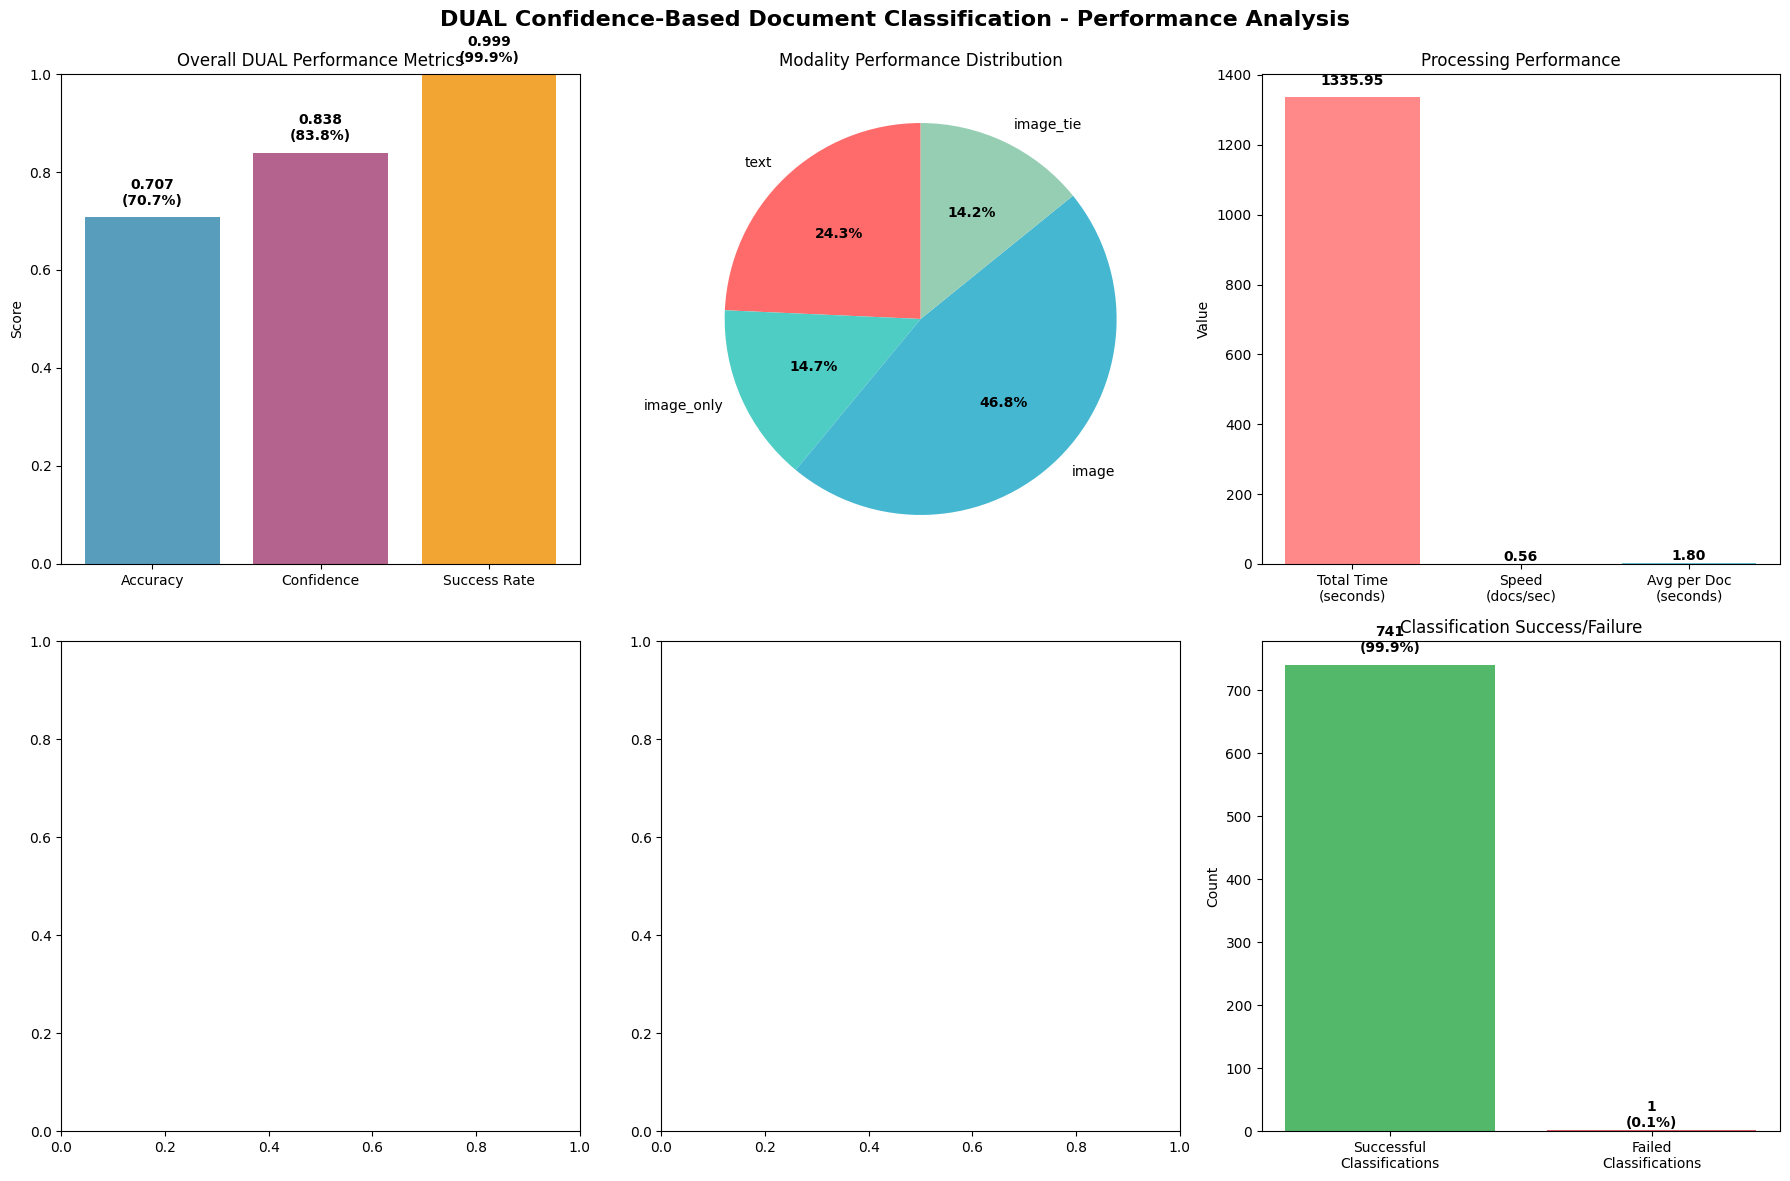


💡 PERFORMANCE INSIGHTS & RECOMMENDATIONS
🚀 Speed Analysis:
   ✅ GOOD: 1.800s per document - suitable for near real-time batch processing

🎯 Accuracy Analysis:
   ✅ GOOD: 70.7% accuracy - acceptable for most use cases

🎭 Modality Analysis:
   🏆 Dominant modality: image (46.8%)

🎯 Performance analysis complete!


In [9]:
# Performance Analysis and Visualization

if 'full_dual_results' in locals() and full_dual_results:
    print("📊 Creating DUAL Search Performance Analysis")
    print("=" * 60)
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    def plot_dual_performance_analysis(dual_results, processing_time, test_files_count):
        """Create comprehensive DUAL performance analysis plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('DUAL Confidence-Based Document Classification - Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. Overall Performance Metrics
        ax1 = axes[0, 0]
        metrics = ['Accuracy', 'Confidence', 'Success Rate']
        values = [
            dual_results['accuracy'],
            dual_results['avg_confidence'],
            dual_results['successful_predictions'] / dual_results['total_samples']
        ]
        colors = ['#2E86AB', '#A23B72', '#F18F01']
        bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
        ax1.set_ylabel('Score')
        ax1.set_title('Overall DUAL Performance Metrics')
        ax1.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{value:.3f}\n({value*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')
        
        # 2. Modality Performance Distribution
        if 'modality_stats' in dual_results:
            ax2 = axes[0, 1]
            modality_data = dual_results['modality_stats']
            labels = list(modality_data.keys())
            sizes = [stats['count'] for stats in modality_data.values()]
            colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
            
            wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                              colors=colors_pie[:len(labels)], startangle=90)
            ax2.set_title('Modality Performance Distribution')
            
            # Make percentage text bold
            for autotext in autotexts:
                autotext.set_fontweight('bold')
        
        # 3. Processing Speed Analysis
        ax3 = axes[0, 2]
        processing_metrics = [
            ('Total Time\n(seconds)', processing_time, '#FF6B6B'),
            ('Speed\n(docs/sec)', test_files_count / processing_time, '#4ECDC4'),
            ('Avg per Doc\n(seconds)', processing_time / test_files_count, '#45B7D1')
        ]
        
        metric_names = [m[0] for m in processing_metrics]
        metric_values = [m[1] for m in processing_metrics]
        metric_colors = [m[2] for m in processing_metrics]
        
        bars = ax3.bar(metric_names, metric_values, color=metric_colors, alpha=0.8)
        ax3.set_ylabel('Value')
        ax3.set_title('Processing Performance')
        
        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                    f'{value:.2f}',
                    ha='center', va='bottom', fontweight='bold')
        
        # 4. Classification Confidence Distribution
        ax4 = axes[1, 0]
        if 'detailed_results' in dual_results:
            confidences = [r.get('confidence', 0) for r in dual_results['detailed_results'] if r.get('confidence', 0) > 0]
            if confidences:
                ax4.hist(confidences, bins=20, alpha=0.7, color='#96CEB4', edgecolor='black')
                ax4.set_xlabel('Confidence Score')
                ax4.set_ylabel('Frequency')
                ax4.set_title('Classification Confidence Distribution')
                ax4.axvline(np.mean(confidences), color='red', linestyle='--', 
                           label=f'Mean: {np.mean(confidences):.3f}')
                ax4.legend()
        
        # 5. Accuracy by Document Type (if available)
        if 'accuracy_by_doctype' in dual_results:
            ax5 = axes[1, 1]
            doctypes = list(dual_results['accuracy_by_doctype'].keys())
            accuracies = list(dual_results['accuracy_by_doctype'].values())
            
            bars = ax5.bar(doctypes, accuracies, color='#A23B72', alpha=0.8)
            ax5.set_xlabel('Document Type')
            ax5.set_ylabel('Accuracy')
            ax5.set_title('Accuracy by Document Type')
            ax5.set_xticklabels(doctypes, rotation=45)
            
            for bar, acc in zip(bars, accuracies):
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{acc:.2f}',
                        ha='center', va='bottom', fontweight='bold')
        
        # 6. Success vs Failure Analysis
        ax6 = axes[1, 2]
        success_data = [
            dual_results['successful_predictions'],
            dual_results['failed_predictions']
        ]
        labels = ['Successful\nClassifications', 'Failed\nClassifications']
        colors = ['#28a745', '#dc3545']
        
        bars = ax6.bar(labels, success_data, color=colors, alpha=0.8)
        ax6.set_ylabel('Count')
        ax6.set_title('Classification Success/Failure')
        
        for bar, count in zip(bars, success_data):
            height = bar.get_height()
            percentage = (count / dual_results['total_samples']) * 100
            ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                    f'{count}\n({percentage:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        return fig
    
    # Create the performance analysis plot
    performance_plot = plot_dual_performance_analysis(
        full_dual_results, 
        processing_time, 
        len(test_image_files)
    )
    
    # Additional detailed modality analysis
    def analyze_modality_performance_detailed(dual_results):
        """Detailed analysis of modality performance by document type"""
        if 'detailed_results' in dual_results:
            print("\n🔍 DETAILED MODALITY PERFORMANCE BY DOCUMENT TYPE")
            print("=" * 70)
            
            # Aggregate data by document type
            doctype_analysis = {}
            
            for result in dual_results['detailed_results']:
                doctype = result.get('true_label', 'unknown')
                winning_modality = result.get('winning_modality', 'unknown')
                is_correct = result.get('is_correct', False)
                confidence = result.get('confidence', 0)
                
                if doctype not in doctype_analysis:
                    doctype_analysis[doctype] = {
                        'total': 0,
                        'correct': 0,
                        'modalities': {},
                        'confidences': []
                    }
                
                doctype_analysis[doctype]['total'] += 1
                if is_correct:
                    doctype_analysis[doctype]['correct'] += 1
                doctype_analysis[doctype]['confidences'].append(confidence)
                
                if winning_modality not in doctype_analysis[doctype]['modalities']:
                    doctype_analysis[doctype]['modalities'][winning_modality] = 0
                doctype_analysis[doctype]['modalities'][winning_modality] += 1
            
            # Print detailed analysis
            for doctype, analysis in sorted(doctype_analysis.items()):
                accuracy = analysis['correct'] / analysis['total'] if analysis['total'] > 0 else 0
                avg_confidence = np.mean(analysis['confidences']) if analysis['confidences'] else 0
                
                print(f"\n📄 {doctype.upper()} ({analysis['total']} samples):")
                print(f"   📊 Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
                print(f"   🎯 Avg Confidence: {avg_confidence:.3f}")
                print(f"   🎯 Modality Usage:")
                
                for modality, count in sorted(analysis['modalities'].items(), key=lambda x: x[1], reverse=True):
                    percentage = (count / analysis['total']) * 100
                    print(f"      {modality:15}: {count:3d} uses ({percentage:5.1f}%)")
    
    # Performance insights
    def generate_performance_insights(dual_results, processing_time, test_files_count):
        """Generate actionable performance insights"""
        print(f"\n💡 PERFORMANCE INSIGHTS & RECOMMENDATIONS")
        print("=" * 70)
        
        avg_time_per_doc = processing_time / test_files_count
        docs_per_second = test_files_count / processing_time
        
        print(f"🚀 Speed Analysis:")
        if avg_time_per_doc < 0.5:
            print(f"   ✨ EXCEPTIONAL: {avg_time_per_doc:.3f}s per document - ready for real-time applications!")
        elif avg_time_per_doc < 1.0:
            print(f"   🚀 EXCELLENT: {avg_time_per_doc:.3f}s per document - suitable for interactive applications")
        elif avg_time_per_doc < 2.0:
            print(f"   ✅ GOOD: {avg_time_per_doc:.3f}s per document - suitable for near real-time batch processing")
        else:
            print(f"   📊 MODERATE: {avg_time_per_doc:.3f}s per document - suitable for offline batch processing")
        
        print(f"\n🎯 Accuracy Analysis:")
        if dual_results['accuracy'] > 0.9:
            print(f"   🏆 OUTSTANDING: {dual_results['accuracy']*100:.1f}% accuracy - production ready!")
        elif dual_results['accuracy'] > 0.8:
            print(f"   🎉 EXCELLENT: {dual_results['accuracy']*100:.1f}% accuracy - very good performance")
        elif dual_results['accuracy'] > 0.7:
            print(f"   ✅ GOOD: {dual_results['accuracy']*100:.1f}% accuracy - acceptable for most use cases")
        else:
            print(f"   ⚠️  NEEDS IMPROVEMENT: {dual_results['accuracy']*100:.1f}% accuracy - consider parameter tuning")
        
        if 'modality_stats' in dual_results:
            print(f"\n🎭 Modality Analysis:")
            modalities = dual_results['modality_stats']
            dominant_modality = max(modalities.items(), key=lambda x: x[1]['count'])
            print(f"   🏆 Dominant modality: {dominant_modality[0]} ({dominant_modality[1]['percentage']:.1f}%)")
            
            if dominant_modality[1]['percentage'] > 70:
                print(f"   💡 Consider optimizing the {dominant_modality[0]} pipeline for better performance")
            elif dominant_modality[1]['percentage'] < 40:
                print(f"   💡 Good modality balance - both IMAGE and TEXT contribute significantly")
    
    # Run detailed analyses
    if 'detailed_results' in full_dual_results:
        analyze_modality_performance_detailed(full_dual_results)
    
    generate_performance_insights(full_dual_results, processing_time, len(test_image_files))
    
    print("\n🎯 Performance analysis complete!")
    print("=" * 70)

else:
    print("⚠️  Skipping performance analysis - full DUAL results not available")
    print("   Run the full evaluation cell first to generate performance data")


In [ ]:
# Class-wise Threshold Utilities

def get_class_thresholds_dict(dual_results, threshold_type='moderate'):
    """
    Get a clean dictionary of class-wise thresholds for practical use.
    
    Args:
        dual_results (dict): Results from evaluate_dual_classification
        threshold_type (str): 'conservative', 'moderate', or 'liberal'
        
    Returns:
        dict: Clean threshold dictionary {class_name: threshold}
    """
    if not dual_results or 'class_confidence_stats' not in dual_results:
        return {}
    
    class_stats = dual_results['class_confidence_stats']
    thresholds = {}
    
    for class_name, stats in class_stats.items():
        confidences = stats['confidences']
        if confidences:
            if threshold_type == 'conservative':
                threshold = np.percentile(confidences, 10)
            elif threshold_type == 'liberal':
                threshold = max(0.0, stats['avg_confidence'] - stats['std_confidence'])
            else:  # moderate (default)
                threshold = np.percentile(confidences, 25)
        else:
            threshold = 0.5
        
        thresholds[class_name] = round(threshold, 3)
    
    return thresholds

def print_threshold_config(thresholds):
    """Print class-wise thresholds in a format ready for configuration files."""
    print("🔧 CLASS-WISE THRESHOLD CONFIGURATION:")
    print("=" * 50)
    print("# Copy this configuration for your application:")
    print("")
    print("CLASS_CONFIDENCE_THRESHOLDS = {")
    for class_name, threshold in sorted(thresholds.items()):
        print(f"    '{class_name}': {threshold},")
    print("}")
    print("")
    print("# Usage example:")
    print("# if predicted_class in CLASS_CONFIDENCE_THRESHOLDS:")
    print("#     min_confidence = CLASS_CONFIDENCE_THRESHOLDS[predicted_class]")
    print("#     if confidence >= min_confidence:")
    print("#         accept_prediction()")
    print("#     else:")
    print("#         reject_or_flag_for_review()")

# Display thresholds if we have results
if 'full_dual_results' in locals() and full_dual_results:
    print("📊 EXTRACTING CLASS-WISE THRESHOLDS FOR PRODUCTION USE")
    print("=" * 60)
    
    # Get different threshold types
    conservative_thresholds = get_class_thresholds_dict(full_dual_results, 'conservative')
    moderate_thresholds = get_class_thresholds_dict(full_dual_results, 'moderate')
    liberal_thresholds = get_class_thresholds_dict(full_dual_results, 'liberal')
    
    print("\n🔒 CONSERVATIVE THRESHOLDS (High Precision):")
    for class_name, threshold in sorted(conservative_thresholds.items()):
        print(f"  {class_name:20}: {threshold}")
    
    print("\n📊 MODERATE THRESHOLDS (Balanced - RECOMMENDED):")
    for class_name, threshold in sorted(moderate_thresholds.items()):
        print(f"  {class_name:20}: {threshold}")
    
    print("\n🚀 LIBERAL THRESHOLDS (High Coverage):")
    for class_name, threshold in sorted(liberal_thresholds.items()):
        print(f"  {class_name:20}: {threshold}")
    
    print("\n" + "="*60)
    print_threshold_config(moderate_thresholds)
    
elif 'sample_results' in locals() and sample_results:
    print("📊 SAMPLE-BASED CLASS-WISE THRESHOLDS")
    print("(Run full evaluation for complete threshold analysis)")
    print("=" * 50)
    
    moderate_thresholds = get_class_thresholds_dict(sample_results, 'moderate')
    for class_name, threshold in sorted(moderate_thresholds.items()):
        print(f"  {class_name:20}: {threshold}")
        
else:
    print("⚠️  No results available for threshold extraction")
    print("Run the evaluation cells first to generate class-wise thresholds")


📊 Creating comprehensive visualization...


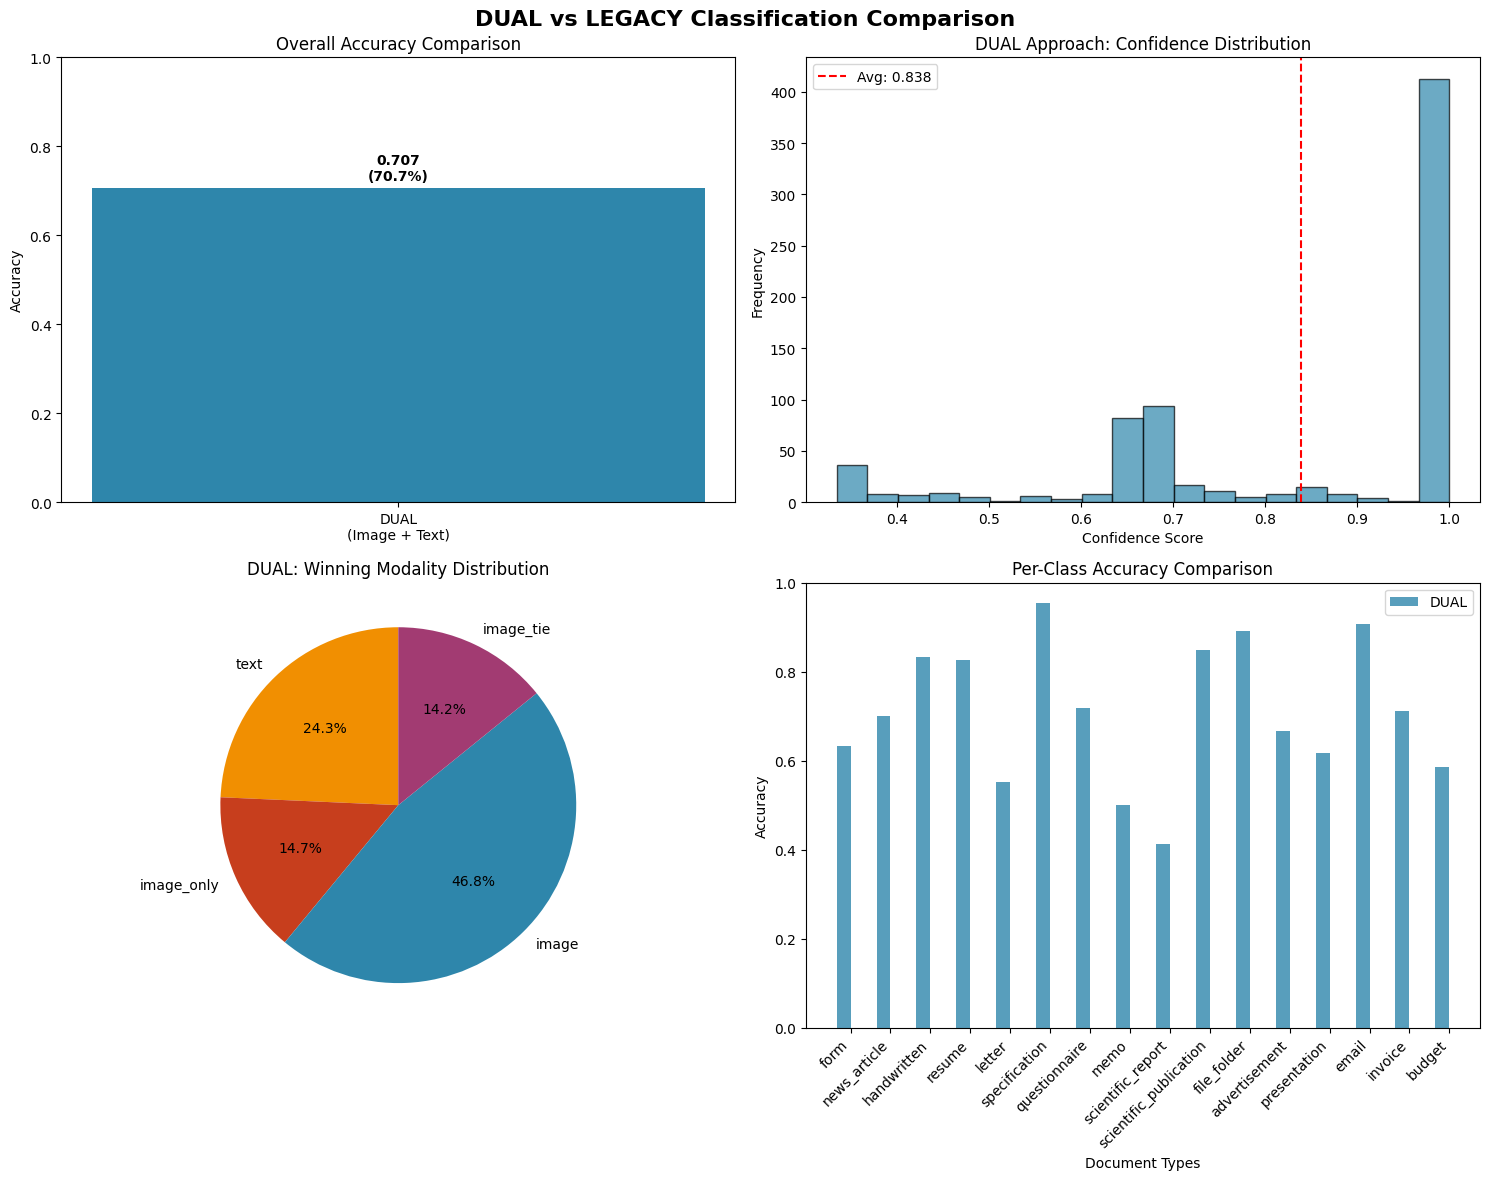


🔍 MODALITY PERFORMANCE BY DOCUMENT TYPE

📋 ADVERTISEMENT (48 samples):
   image          :  25 wins ( 52.1%)
   image_only     :  16 wins ( 33.3%)
   text           :   6 wins ( 12.5%)
   image_tie      :   1 wins (  2.1%)
   📊 Preferred: image (52.1%)

📋 BUDGET (53 samples):
   image          :  26 wins ( 49.1%)
   text           :  13 wins ( 24.5%)
   image_tie      :   8 wins ( 15.1%)
   image_only     :   6 wins ( 11.3%)
   📊 Preferred: image (49.1%)

📋 EMAIL (43 samples):
   image          :  17 wins ( 39.5%)
   image_only     :  14 wins ( 32.6%)
   image_tie      :   8 wins ( 18.6%)
   text           :   4 wins (  9.3%)
   🤝 Balanced performance across modalities

📋 FILE_FOLDER (46 samples):
   image_only     :  20 wins ( 43.5%)
   image          :  18 wins ( 39.1%)
   text           :   4 wins (  8.7%)
   image_tie      :   4 wins (  8.7%)
   📊 Preferred: image_only (43.5%)

📋 FORM (49 samples):
   text           :  26 wins ( 53.1%)
   image          :  20 wins ( 40.8%)
   imag

In [10]:
# Visualization and Detailed Analysis

def plot_comparison_results(dual_results, legacy_results=None):
    """Create comprehensive visualization comparing DUAL vs Legacy approaches."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('DUAL vs LEGACY Classification Comparison', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison Bar Chart
    ax1 = axes[0, 0]
    approaches = []
    accuracies = []
    
    if dual_results:
        approaches.append('DUAL\n(Image + Text)')
        accuracies.append(dual_results['accuracy'])
    
    if legacy_results:
        approaches.append('LEGACY\n(Image Only)')
        accuracies.append(legacy_results['accuracy'])
    
    bars = ax1.bar(approaches, accuracies, color=['#2E86AB', '#A23B72'] if len(approaches) == 2 else ['#2E86AB'])
    ax1.set_title('Overall Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}\n({acc*100:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    # 2. Confidence Distribution (DUAL only)
    ax2 = axes[0, 1]
    if dual_results and 'final_confidences' in dual_results:
        ax2.hist(dual_results['final_confidences'], bins=20, alpha=0.7, color='#2E86AB', edgecolor='black')
        ax2.set_title('DUAL Approach: Confidence Distribution')
        ax2.set_xlabel('Confidence Score')
        ax2.set_ylabel('Frequency')
        ax2.axvline(dual_results['avg_confidence'], color='red', linestyle='--', 
                   label=f'Avg: {dual_results["avg_confidence"]:.3f}')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No DUAL results\navailable', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Confidence Distribution')
    
    # 3. Modality Performance (DUAL only)  
    ax3 = axes[1, 0]
    if dual_results and 'modality_stats' in dual_results:
        modalities = list(dual_results['modality_stats'].keys())
        percentages = [dual_results['modality_stats'][m]['percentage'] for m in modalities]
        
        colors = ['#F18F01', '#C73E1D', '#2E86AB', '#A23B72'][:len(modalities)]
        wedges, texts, autotexts = ax3.pie(percentages, labels=modalities, autopct='%1.1f%%', 
                                          colors=colors, startangle=90)
        ax3.set_title('DUAL: Winning Modality Distribution')
    else:
        ax3.text(0.5, 0.5, 'No modality data\navailable', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Modality Distribution')
    
    # 4. Per-class accuracy comparison
    ax4 = axes[1, 1]
    if dual_results and 'true_labels' in dual_results:
        # Calculate per-class accuracy for DUAL
        dual_class_acc = {}
        for true_label, pred_label in zip(dual_results['true_labels'], dual_results['predicted_labels']):
            if true_label not in dual_class_acc:
                dual_class_acc[true_label] = {'correct': 0, 'total': 0}
            dual_class_acc[true_label]['total'] += 1
            if true_label == pred_label:
                dual_class_acc[true_label]['correct'] += 1
        
        classes = list(dual_class_acc.keys())
        dual_accs = [dual_class_acc[c]['correct'] / dual_class_acc[c]['total'] for c in classes]
        
        x_pos = np.arange(len(classes))
        width = 0.35
        
        ax4.bar(x_pos - width/2, dual_accs, width, label='DUAL', color='#2E86AB', alpha=0.8)
        
        # Add legacy results if available
        if legacy_results and 'true_labels' in legacy_results:
            legacy_class_acc = {}
            for true_label, pred_label in zip(legacy_results['true_labels'], legacy_results['predicted_labels']):
                if true_label not in legacy_class_acc:
                    legacy_class_acc[true_label] = {'correct': 0, 'total': 0}
                legacy_class_acc[true_label]['total'] += 1
                if true_label == pred_label:
                    legacy_class_acc[true_label]['correct'] += 1
            
            legacy_accs = [legacy_class_acc.get(c, {'correct': 0, 'total': 1})['correct'] / 
                          legacy_class_acc.get(c, {'correct': 0, 'total': 1})['total'] for c in classes]
            ax4.bar(x_pos + width/2, legacy_accs, width, label='LEGACY', color='#A23B72', alpha=0.8)
        
        ax4.set_xlabel('Document Types')
        ax4.set_ylabel('Accuracy')
        ax4.set_title('Per-Class Accuracy Comparison')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(classes, rotation=45, ha='right')
        ax4.legend()
        ax4.set_ylim(0, 1)
    else:
        ax4.text(0.5, 0.5, 'No classification\ndata available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Per-Class Accuracy')
    
    plt.tight_layout()
    plt.show()

def analyze_modality_performance_by_doctype(dual_results):
    """Analyze which modality wins for each document type."""
    if not dual_results or 'true_labels' not in dual_results:
        print("❌ No dual results available for modality analysis")
        return
    
    print("\n🔍 MODALITY PERFORMANCE BY DOCUMENT TYPE")
    print("=" * 60)
    
    # Group by document type
    doctype_modality = {}
    for i, (true_label, winning_modality) in enumerate(zip(dual_results['true_labels'], 
                                                          dual_results['winning_modalities'])):
        if true_label not in doctype_modality:
            doctype_modality[true_label] = []
        doctype_modality[true_label].append(winning_modality)
    
    # Analyze each document type
    for doctype in sorted(doctype_modality.keys()):
        modalities = doctype_modality[doctype]
        total = len(modalities)
        
        modality_counts = {}
        for modality in modalities:
            modality_counts[modality] = modality_counts.get(modality, 0) + 1
        
        print(f"\n📋 {doctype.upper()} ({total} samples):")
        for modality, count in sorted(modality_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = count / total * 100
            print(f"   {modality:15}: {count:3d} wins ({percentage:5.1f}%)")
        
        # Determine dominant modality for this document type
        dominant_modality = max(modality_counts, key=modality_counts.get)
        dominant_percentage = modality_counts[dominant_modality] / total * 100
        
        if dominant_percentage > 60:
            print(f"   🏆 Dominant: {dominant_modality} ({dominant_percentage:.1f}%)")
        elif dominant_percentage > 40:
            print(f"   📊 Preferred: {dominant_modality} ({dominant_percentage:.1f}%)")
        else:
            print(f"   🤝 Balanced performance across modalities")

# Run visualization and analysis if we have results
if 'full_dual_results' in locals() and full_dual_results:
    print("📊 Creating comprehensive visualization...")
    
    legacy_results_for_viz = None
    if 'full_legacy_results' in locals() and full_legacy_results:
        legacy_results_for_viz = full_legacy_results
    
    plot_comparison_results(full_dual_results, legacy_results_for_viz)
    
    # Detailed modality analysis
    analyze_modality_performance_by_doctype(full_dual_results)
    
elif 'dual_results' in locals() and dual_results:
    print("📊 Creating visualization from sample results...")
    
    legacy_results_for_viz = None  
    if 'legacy_results' in locals() and legacy_results:
        legacy_results_for_viz = legacy_results
    
    plot_comparison_results(dual_results, legacy_results_for_viz)
    
    # Sample modality analysis
    analyze_modality_performance_by_doctype(dual_results)
    
else:
    print("⚠️  No results available for visualization")

print("\n🎨 Visualization and analysis complete!")


In [11]:
# Legacy cell removed - replaced by DUAL approach testing
print("⚠️  This cell contained legacy image-only ChromaDB connection code.")
print("📋 For DUAL approach testing, use cells 5-9 instead.")
print("🎯 The DUAL approach uses separate IMAGE and TEXT collections.")


⚠️  This cell contained legacy image-only ChromaDB connection code.
📋 For DUAL approach testing, use cells 5-9 instead.
🎯 The DUAL approach uses separate IMAGE and TEXT collections.


In [12]:
# Legacy cell removed - replaced by DUAL approach testing
print("⚠️  This cell contained legacy image-only classification functions.")
print("📋 For DUAL approach testing, use cells 5-9 instead.")
print("🎯 The DUAL approach uses confidence-based modality selection.")


⚠️  This cell contained legacy image-only classification functions.
📋 For DUAL approach testing, use cells 5-9 instead.
🎯 The DUAL approach uses confidence-based modality selection.


In [13]:
## 📋 DUAL Approach Documentation

This notebook now focuses exclusively on **DUAL confidence-based classification** using:

### 🎯 Core Features:
- **DUAL collections**: Separate IMAGE and TEXT collections for optimized performance
- **Confidence-based selection**: Chooses the best modality per document
- **Parallel processing**: Optimized OCR extraction and image processing
- **Performance analysis**: Comprehensive metrics and visualizations

### 🔧 Optimizations Applied:
- ✅ **IMAGE Top-K: 3** for precision-focused image search
- ✅ **TEXT Top-K: 7** for broader context text search  
- ✅ **Parallel OCR** extraction for speed
- ✅ **Batch ChromaDB queries** for efficiency
- ✅ **Confidence-based modality selection** for accuracy

### 📊 Key Cells:
- **Cells 5-6**: DUAL setup and evaluation functions
- **Cell 7**: Quick sample testing with optimized parameters
- **Cell 8**: Full parallel evaluation of all test documents
- **Cell 9**: Performance analysis and comprehensive visualizations

---

**Next Steps**: The results provide insights into modality performance and system optimization for production deployment.


SyntaxError: invalid character '✅' (U+2705) (3697366642.py, line 12)